<a href="https://colab.research.google.com/github/leukschrauber/LearningPortfolio/blob/main/learn_portfolio_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Portfolio
*by Fabian Leuk (csba6437/12215478)*

## Session 6: Artifical Neural Networks

In my learning portfolios 3 and 4, I have already experimented on Artificial Neural Networks using the titanic dataset from kaggle. (https://www.kaggle.com/competitions/titanic/overview)

In this Notebook, I will revise my solution from Learning Portfolio 4 (https://github.com/leukschrauber/LearningPortfolio/blob/main/learn_portfolio_4.ipynb) using the insights of this fast AI lesson (https://course.fast.ai/Lessons/lesson5.html). In particular, I will use insights from feature engineering and ensembling.

### Key Learnings




*   FastAI is a bit difficult to handle sometimes. I tried to connect the learner to an SKLearn-Data-Preprocessing pipeline but failed to do so because of cryptic error messages of fastAI. Sometimes it feels like fastAI is not as mature as other ML librariers such as transformers.
*   learner.lr_find() can be quite useful as I struggled in the past to guess a good learning rate for my models
*   I learned that I should not throw columns away blindly. As demonstrated by the fastAI lesson, the columns "Ticket" and "Name" can be transformed into valuable model inputs. In my recent Learning Portfolios, I simply discarded them.
* @ is the python operator for matrix multiplication
* sympy is a python library which can be used to plot symbolic expressions
* pytorch relies on CUDA/GPU making broadcasting and matrix multiplications incredibly fast
* Although I prefer SKLearn's train_test_split(), fastAI as well provides a RandomSplitter() to do the job
* Although I prefer SKLearn's data preprocessing pipelines, fastAI's TabularPandas can do the most common data transformations as well
* Creating multiple models and averaging their predictions is referred to as ensembling and is oftentimes superior to single models predictions
* Wrapping data transformations into functions is useful as code is needed multiple times (e.g. for every new test set)







### Application: Predicting Titanic Mortality


#### Data Import

In [4]:
import pandas as pd
from google.colab import drive
from google.colab import data_table
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
data_table.enable_dataframe_formatter()

drive.mount('/content/drive')
data = pd.read_csv("/content/drive/My Drive/SE_Digital_Organizations/titanic_train.csv")

Mounted at /content/drive


In [2]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
from fastai.vision.all import *
from fastbook import *
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

#### Data Preparation

When preparing the data, we will engineer features as presented in the fast AI notebook. Additionally, I will use KNNImputer for certain features like in my recent Learning Portfolio, as I think it provides better results than replacing everything by the mode.

Unfortunately, I haven't been able to connect my SKLearn Pipeline to the fastAI tabular learn package as fastAI provided cryptic error messages.


In [34]:
data = pd.read_csv("/content/drive/My Drive/SE_Digital_Organizations/titanic_train.csv")

# define function to apply to each row
def passenger_type(row):
    if row['Sex'] == 'female' and row['Age'] >= 18:
        return 0
    elif row['Age'] <= 18:
        return 1
    elif row['Sex'] == 'male' and row['Age'] >= 18:
        return 2
    else:
        return None

def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))
    df['Passenger Type'] = df.apply(passenger_type, axis=1)

add_features(data)

def impute(df):
  # impute passenger age using k-nearest neighbors
  from sklearn.impute import KNNImputer

  imputer = KNNImputer()
  data_num = df.select_dtypes(include=[np.number])
  imputer.fit(data_num)
  data_new = imputer.transform(data_num)
  df["Age"] = data_new[:,3]

  # impute embarkation point by mode
  from sklearn.impute import SimpleImputer

  s_imputer = SimpleImputer(strategy="most_frequent")
  s_imputer.fit(df)
  data_new = s_imputer.transform(df)
  df["Embarked"] = data_new[:,3]
  df["Title"] = data_new[:,3]
  df["Passenger Type"] = data_new[:,3]


impute(data)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     891 non-null    int64  
 1   Survived        891 non-null    int64  
 2   Pclass          891 non-null    int64  
 3   Name            891 non-null    object 
 4   Sex             891 non-null    object 
 5   Age             891 non-null    float64
 6   SibSp           891 non-null    int64  
 7   Parch           891 non-null    int64  
 8   Ticket          891 non-null    object 
 9   Fare            891 non-null    float64
 10  Cabin           204 non-null    object 
 11  Embarked        891 non-null    object 
 12  LogFare         891 non-null    float64
 13  Deck            203 non-null    object 
 14  Family          891 non-null    int64  
 15  Alone           891 non-null    bool   
 16  TicketFreq      891 non-null    int64  
 17  Title           891 non-null    obj

#### Training

For Training, I used the code from the fastAI lesson and added some additional columns to the categories. I used a learning rate of 0.1 as it was determined suitabkle by the lr_find() method.

SuggestedLRs(slide=0.17378008365631104, valley=0.013182567432522774)

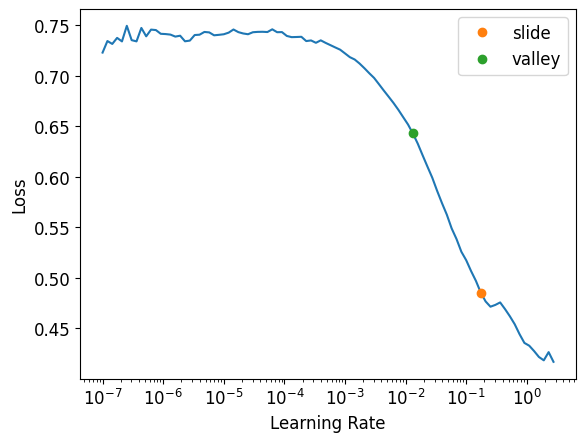

In [23]:
from fastai.tabular.all import *

splits = RandomSplitter(seed=42)(data)

dls = TabularPandas(
    data, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title", "Passenger Type"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders(path=".")
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
learn.lr_find(suggest_funcs=(slide, valley))

In [44]:
learn.fit(32, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.000019,0.802660,0.820225,00:00
1,0.000015,0.808959,0.820225,00:00
2,0.000024,0.811124,0.825843,00:00
3,0.000024,0.816605,0.820225,00:00
4,0.000021,0.830320,0.803371,00:00
5,0.000019,0.844696,0.797753,00:00
6,0.000020,0.827574,0.820225,00:00
7,0.000020,0.843012,0.820225,00:00
8,0.000018,0.860151,0.797753,00:00
9,0.000015,0.869265,0.803371,00:00


#### Testing

For testing, I prepared the data just as the training data using the defined method add_features and impute. The learner took care of the rest of data preparation.

I submitted results for both a single trained model as well as a ensemble model, which averaged the predictions over 8 models.

The single model scored an accuracy of 72 %, while the ensemble scored an accuracy of 73 %. The ensemble model score is still worse than a single TLU i trained on Learning Portfolio 3. I believe it is because the data preparation was not quite as good as my SKLearn-Pipeline in Assignment 3.


In [35]:
tst_df = pd.read_csv("/content/drive/My Drive/SE_Digital_Organizations/titanic_test.csv")
tst_df['Fare'] = tst_df.Fare.fillna(0)
add_features(tst_df)
impute(tst_df)

tst_dl = learn.dls.test_dl(tst_df)



In [45]:
preds,_ = learn.get_preds(dl=tst_dl)

In [46]:
tst_df['Survived'] = (preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('/content/drive/My Drive/SE_Digital_Organizations/single_preds.csv', index=False)

In [40]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
    with learn.no_bar(),learn.no_logging(): learn.fit(10, lr=0.1)
    return learn.get_preds(dl=tst_dl)[0]

In [41]:
learns = [ensemble() for _ in range(8)]

In [42]:
ens_preds = torch.stack(learns).mean(0)

In [43]:
tst_df['Survived'] = (ens_preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv("/content/drive/My Drive/SE_Digital_Organizations/ensemble_preds.csv", index=False)

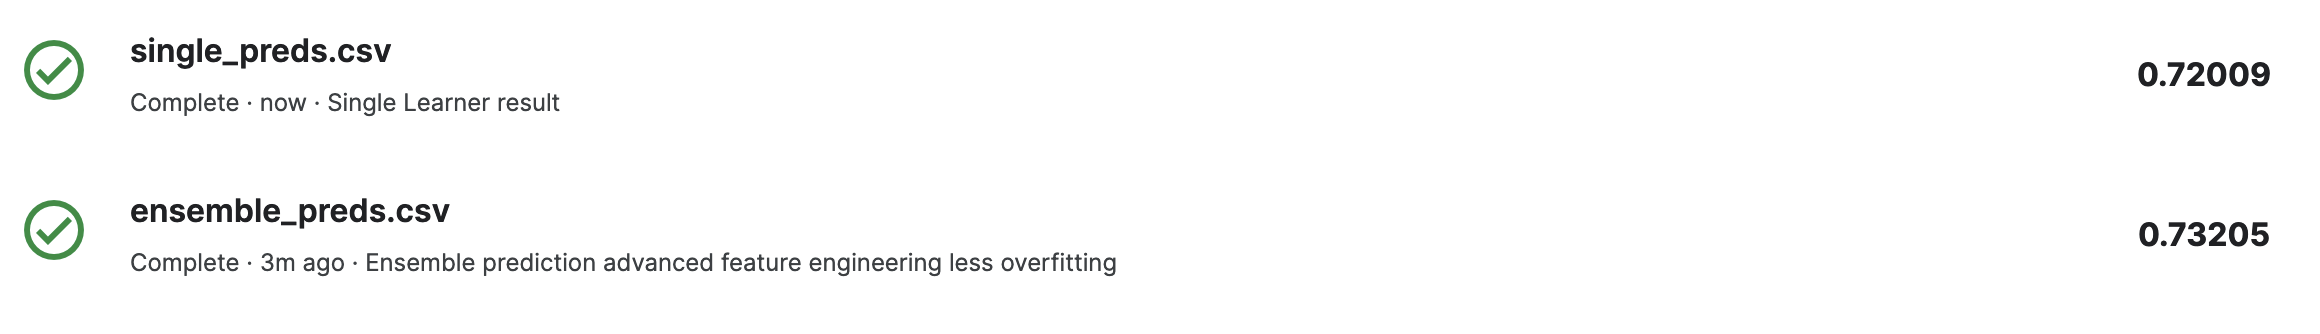